# Theoretical Recurrence Interval

__Description__:

__Input__: 

__Output__: 

---
## Load Libraries, Parameters, and File Paths:
### Libraries:

In [1]:
import os
import json
import numpy as np
import pandas as pd
import pathlib as pl
from matplotlib import pyplot as plt

### Parameters:
#### Site specific:

In [2]:
Project_Area = 'Passaic' # Project area name

root_dir = pl.Path(r'C:\Users\sputnam\Desktop\PFRA_Production\Pluvial\{0}'.format(Project_Area))
outputs_dir = root_dir/'Outputs'

#### Project specific (global):

In [3]:
binwidth = 0.1       # [inches]; increment for binning the excess rainfall amount
RI_max = 3000

verbose = True        # Option to display print statements
display_plots = True  # Option to display plots

### File Paths:
#### Weights:

In [4]:
weight_files = []
for f in outputs_dir.glob('*.json'):
    if 'Weights' in f.stem and 'TRI' not in f.stem: 
        weight_files.append(f)       
        print(f)

C:\Users\sputnam\Desktop\PFRA_Production\Pluvial\Passaic\Outputs\Passaic_P05_D01_Weights.json


#### Forcing:

In [5]:
forcing_files = []
for f in outputs_dir.glob('**/*.json'):
    if 'Forcing' in f.parent.stem:
        forcing_files.append(f)
        print(f)

C:\Users\sputnam\Desktop\PFRA_Production\Pluvial\Passaic\Outputs\Passaic_P05_Forcing\Passaic_P05_D01.json


---
## Calculate the Theoretical Recurrence Interval:

In [6]:
dic = {}
dic_vol = {}
forcing_file = forcing_files[0]

_, Pluvial_Model, Domain = forcing_file.stem.split('_')

for w in weight_files:
    if Pluvial_Model in w.stem:
        weight_file = w
        
with open(forcing_file) as f:
        ff_dic =  json.load(f)

with open(weight_file) as f:
        wt =  json.load(f)  
        
mainBCN = list(wt['BCName'].keys())[0]

df = pd.DataFrame()
df['Events'] = list(wt['BCName'][mainBCN].keys())
df['Weight'] = list(wt['BCName'][mainBCN].values())    
df = df.set_index('Events')
for d in list(ff_dic.keys()):
    for k, v in ff_dic[d]['BCName'][Domain].items():
        df.loc[k, 'Volume'] = sum(v)
        df.loc[k, 'Dur'] = d
df = df.reset_index().sort_values(by=['Volume'], ascending = True).set_index('Events') 

binmin = min(df['Volume'])
binmax = max(df['Volume'])
bins = np.arange(binmin, binmax+binwidth, binwidth)

lst = []
for i, b in enumerate(bins[:]):
    if i==0:
        weight = sum(df[(0.0 == df['Volume'])]['Weight'])
    else:
        weight = sum(df[(bins[i-1]  < df['Volume']) & (df['Volume']<=b)]['Weight'])
    lst.append((b, weight))

binned  = pd.DataFrame()
binned['Volume'] = [i[0] for i in lst]
binned['Weight'] = [i[1] for i in lst]
binned['Cumulative'] = binned['Weight'].cumsum()
binned['Theoretical RI'] = 1.0/(0.5-binned['Cumulative'])

76


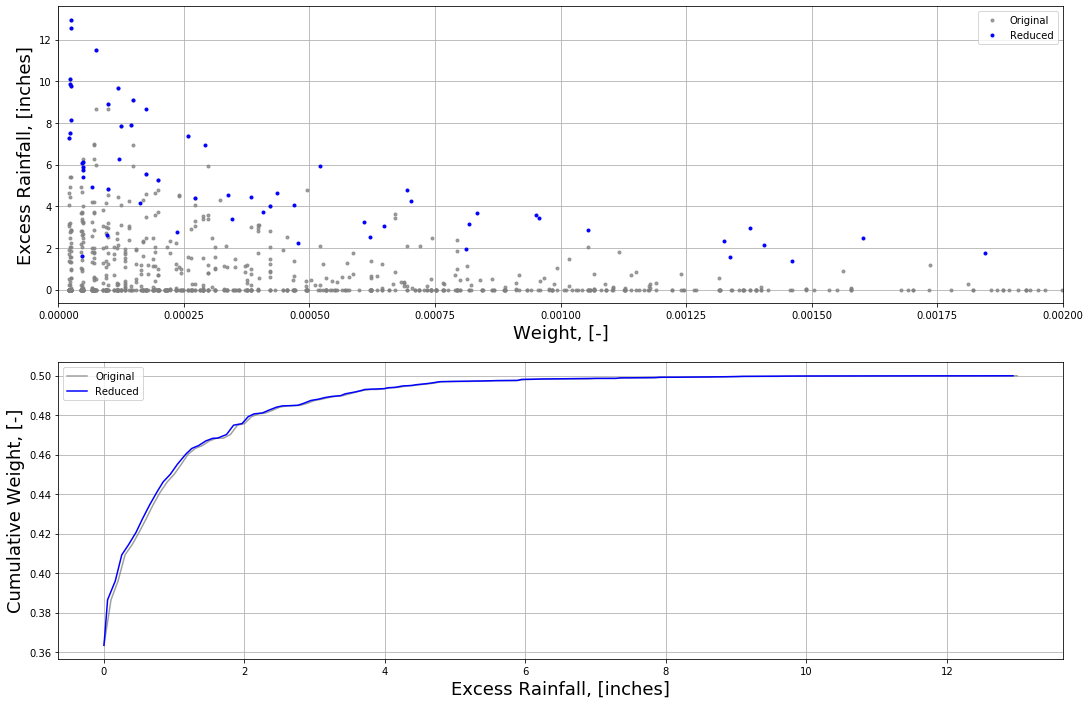

In [7]:
vavg = []
for i, b in enumerate(binned['Volume']):
    if b==0:
        vavg.append(0.0)
    elif b>0:
        vavg.append((b+binned['Volume'][i-1])/2)
binned['Vavg'] = vavg 

event = []
for vavg in binned['Vavg']:
    diff = df['Volume']-vavg
    event.append(diff[diff.abs().argsort()].index[0])
binned['Event'] = event    
binned.head()

unique_events = list(set(list(binned['Event'])))
edf = pd.DataFrame(data = {'Event': unique_events})
for i, e in enumerate(edf['Event']):
    edf.loc[i, 'Weight'] = sum(binned[binned['Event']==e]['Weight']) 
    edf.loc[i, 'Volume'] = df.loc[e]['Volume']
edf = edf[edf['Weight']>0.0].copy(deep=True)
assert np.round(sum(edf['Weight']), 2) == 0.5 , 'Total weight does not equal 0.5 as expected'
edf = edf.sort_values('Volume').reset_index(drop = True)
edf['Cumulative'] = edf['Weight'].cumsum()
print(edf.shape[0])  

fig, ax = plt.subplots(2, 1, figsize=(18, 12))
ax[0].plot(df['Weight'], df['Volume'], linestyle = '', marker = '.' , label = 'Original', color = 'gray', alpha = 0.75)
ax[0].plot(edf['Weight'], edf['Volume'], linestyle = '', marker = '.', color = 'blue', label = 'Reduced')
ax[0].set_xlabel('Weight, [-]', fontsize = 18)
ax[0].set_ylabel('Excess Rainfall, [inches]', fontsize=18)
ax[0].set_xlim([0, 0.002])
ax[0].legend()
ax[0].grid()    
ax[1].plot(binned['Volume'], binned['Cumulative'], linestyle = '-', marker = '', label = 'Original', color = 'gray', alpha = 0.75)
ax[1].plot(edf['Volume'], edf['Cumulative'], linestyle = '-', marker = '', color = 'blue', label = 'Reduced')
ax[1].set_xlabel('Excess Rainfall, [inches]', fontsize = 18)
ax[1].set_ylabel('Cumulative Weight, [-]', fontsize=18)
ax[1].legend()
ax[1].grid()   

In [8]:
edic = {'BCName':{mainBCN:{}}}
for i, e in enumerate(edf['Event']):
    edic['BCName'][mainBCN][e] = edf.loc[i]['Weight']
with open(outputs_dir/'{0}_{1}_{2}_Weights_TRI.json'.format(Project_Area, Pluvial_Model, mainBCN), 'w') as f:
    json.dump(edic, f)
    
edic['BCName']['D01']    

{'E0001': 0.3635166601569678,
 'E0170': 0.023040208364970293,
 'E1135': 0.009510034444716856,
 'E0063': 0.013268838825681094,
 'E0062': 0.005104759882624336,
 'E1087': 0.006277944588944711,
 'E3232': 0.0068277002859186255,
 'E1067': 0.0071425854775573035,
 'E1140': 0.0063311273307123574,
 'E3066': 0.005216074697455179,
 'E1138': 0.0038780390067733785,
 'E0179': 0.005035905100199849,
 'E1136': 0.005240226107290514,
 'E0156': 0.0028181253122348308,
 'E0217': 0.0014600120449017712,
 'E1126': 0.00234126894611179,
 'E1107': 0.0013382450131993915,
 'E2201': 4.792580950673737e-05,
 'E3181': 0.0018455552078261697,
 'E3012': 0.004721800506923461,
 'E0135': 0.00081167790276079,
 'E1158': 0.0035237141574418628,
 'E2156': 0.0014044671297216214,
 'E3240': 0.0004772140189528907,
 'E3132': 0.0013257457110362198,
 'E2224': 0.0016024827627817595,
 'E3176': 0.0006211821907969685,
 'E1183': 9.662049307711387e-05,
 'E1211': 0.00023688842992516533,
 'E3243': 0.0010549257223020012,
 'E1142': 0.0013781420075

---
## End